# RNN Time Series for Flu Level Predictions

In [ ]:
# Author Om Soni
# DSA6100
# Week 9 Journal
# Use RNN to Predict Flu activity from CDC Flu Level DataSet (Michigan Data)

In [31]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

Total Data = 492 weeks


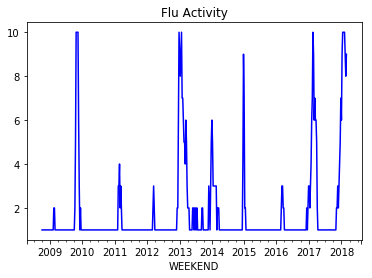

WEEKEND
2008-10-04    1
2008-10-11    1
2008-10-18    1
2008-10-25    1
2008-11-01    1
2008-11-08    1
2008-11-15    1
2008-11-22    1
2008-11-29    1
2008-12-06    1
Name: ACTIVITY LEVEL, dtype: int64

In [33]:
from pandas import Series
def parser(x):
    return pd.to_datetime(x, format='%m/%d/%y')
series = pd.read_csv('../FluPredictors.csv',  header=0 , parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print('Total Data = {0} weeks'.format(len(series)))
series.plot(c='b', title='Flu Activity')
plt.show()
series.head(10)


#### Convert Flu data into array that can be broken up into training "batches" that we will feed into our RNN model.  

In [41]:
TS = np.array(series)
num_periods = 50
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)
print (len(x_batches))
print (len(y_batches))
print (x_batches.shape)
print (y_batches.shape)

9
9
(9, 50, 1)
(9, 50, 1)


#### Pull out our test data

In [42]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    testY = TS[-(num_periods):].reshape(-1, num_periods, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 50, 1)
[[[ 6]
  [ 6]
  [ 5]
  [ 2]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 2]
  [ 2]
  [ 3]
  [ 2]
  [ 3]
  [ 4]
  [ 5]
  [ 7]
  [ 6]
  [ 9]
  [10]
  [10]
  [10]
  [10]
  [ 9]
  [ 8]]]


In [36]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 50      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [37]:
epochs = 10000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    #print(y_pred)

0 	MSE: 2504.5256
100 	MSE: 293.49393
200 	MSE: 227.9141
300 	MSE: 185.46738
400 	MSE: 148.12256
500 	MSE: 128.06212
600 	MSE: 115.34688
700 	MSE: 132.6329
800 	MSE: 80.624794
900 	MSE: 71.0893
1000 	MSE: 120.3263
1100 	MSE: 57.485165
1200 	MSE: 53.351795
1300 	MSE: 51.50996
1400 	MSE: 48.369583
1500 	MSE: 46.08147
1600 	MSE: 43.605465
1700 	MSE: 41.83415
1800 	MSE: 44.726776
1900 	MSE: 39.179974
2000 	MSE: 39.88624
2100 	MSE: 35.94564
2200 	MSE: 35.085987
2300 	MSE: 33.07343
2400 	MSE: 31.777182
2500 	MSE: 30.378433
2600 	MSE: 48.262417
2700 	MSE: 29.884993
2800 	MSE: 27.332556
2900 	MSE: 87.09444
3000 	MSE: 25.13123
3100 	MSE: 23.513912
3200 	MSE: 22.533186
3300 	MSE: 21.2455
3400 	MSE: 20.492891
3500 	MSE: 19.942146
3600 	MSE: 43.875595
3700 	MSE: 23.585678
3800 	MSE: 21.354881
3900 	MSE: 20.214792
4000 	MSE: 19.340418
4100 	MSE: 17.734594
4200 	MSE: 17.182816
4300 	MSE: 16.522297
4400 	MSE: 16.431438
4500 	MSE: 15.938154
4600 	MSE: 24.63171
4700 	MSE: 15.573775
4800 	MSE: 15.196898

In [46]:
#### Actual vs predictions against test batch 

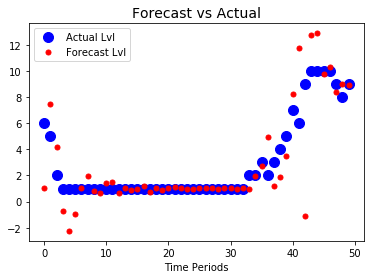

In [47]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual Lvl")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast Lvl")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

